Setting Up the Environment

In [44]:
# Install required packages for Bayesian Decision Network modeling
!pip install pyagrum pandas numpy

In [45]:
import pandas as pd

# Load the uploaded CSV file
file_path = "data/INVEST_clean.csv"
data = pd.read_csv(file_path)

# Display the first few rows of the data to understand its structure
data.head()

,Date,Beta Monthly Leveraged,Beta Monthly Unleveraged,Beta Weekly Leveraged,ShareBeta,Price,Open,PE,Name,Debt/EquityIndustry,...,MarketRateOfReturn,RiskFreeRateOfReturn,PEMarket,PESector,EPS,PEYear,ROAE,ROE,Debt/Equity,ShareholdersEquity
0,2009-01-31,0.6654,0.5952,0.5796,0.5185,9718,10751,7.693,WLSN.BAYLY HOLMES-OVCON,1.86,...,13.24,9.06,9.053,9.160,1610.8,6.6482,43.2376,37.3206,2.7983,2384550
1,2009-02-28,0.7857,0.7028,0.5801,0.5189,8500,9900,5.403,WLSN.BAYLY HOLMES-OVCON,1.86,...,13.24,9.06,8.205,8.715,1610.8,6.6482,43.2376,37.3206,2.7983,2384550
2,2009-03-31,0.6346,0.5676,0.5384,0.4816,8509,8500,5.409,WLSN.BAYLY HOLMES-OVCON,1.86,...,13.24,9.06,9.681,8.880,1610.8,6.6482,43.2376,37.3206,2.7983,2384550
3,2009-04-30,0.6987,0.6250,0.5767,0.5159,10001,8850,6.357,WLSN.BAYLY HOLMES-OVCON,1.86,...,13.24,9.06,9.834,9.457,1610.8,6.6482,43.2376,37.3206,2.7983,2384550
4,2009-05-31,0.6445,0.5765,0.5821,0.5207,10355,9915,6.582,WLSN.BAYLY HOLMES-OVCON,1.86,...,13.24,9.06,10.721,11.149,1610.8,6.6482,43.2376,37.3206,2.7983,2384550


Creating the basic structure for the BDN model, adding some example nodes and relationships to reflect a simplified investment decision framework.

In [46]:
# Refine the baseline BDN structure based on the new INVEST structure

# Create a new Bayesian Network for the refined INVEST system
refined_bn = gum.BayesNet("Refined_INVEST_BDN")

# Define the nodes and their states with more granularity
refined_bn.add(gum.LabelizedVariable("MarketCondition", "Overall Market Sentiment", 2))  # States: Good, Bad
refined_bn.add(gum.LabelizedVariable("SectorPerformance", "Sector-specific Performance", 2))  # States: Positive, Negative
refined_bn.add(gum.LabelizedVariable("SharePerformance", "Performance of Individual Shares", 3))  # States: High, Medium, Low
refined_bn.add(gum.LabelizedVariable("EPS", "Earnings Per Share", 3))  # States: High, Medium, Low
refined_bn.add(gum.LabelizedVariable("ROE", "Return on Equity", 3))  # States: High, Medium, Low
refined_bn.add(gum.LabelizedVariable("ValueIndicator", "Value Investing Indicator", 2))  # States: Attractive, Unattractive

# Define relationships between the nodes based on investment logic
refined_bn.addArc("MarketCondition", "SectorPerformance")
refined_bn.addArc("SectorPerformance", "SharePerformance")
refined_bn.addArc("EPS", "ValueIndicator")
refined_bn.addArc("ROE", "ValueIndicator")
refined_bn.addArc("ValueIndicator", "SharePerformance")  # Value influences SharePerformance

# Define CPTs for each node
# CPT for MarketCondition (prior probabilities)
refined_bn.cpt("MarketCondition").fillWith([0.6, 0.4])  # 60% Good, 40% Bad

# CPT for SectorPerformance given MarketCondition
refined_bn.cpt("SectorPerformance")[{"MarketCondition": 0}] = [0.7, 0.3]  # When Market is Good: 70% Positive, 30% Negative
refined_bn.cpt("SectorPerformance")[{"MarketCondition": 1}] = [0.2, 0.8]  # When Market is Bad: 20% Positive, 80% Negative

# CPT for EPS (prior probabilities)
refined_bn.cpt("EPS").fillWith([0.4, 0.4, 0.2])  # 40% High, 40% Medium, 20% Low

# CPT for ROE (prior probabilities)
refined_bn.cpt("ROE").fillWith([0.3, 0.5, 0.2])  # 30% High, 50% Medium, 20% Low

# CPT for ValueIndicator given EPS and ROE
refined_bn.cpt("ValueIndicator")[{"EPS": 0, "ROE": 0}] = [0.8, 0.2]  # High EPS and High ROE: 80% Attractive, 20% Unattractive
refined_bn.cpt("ValueIndicator")[{"EPS": 2, "ROE": 2}] = [0.1, 0.9]  # Low EPS and Low ROE: 10% Attractive, 90% Unattractive
# Other configurations...
refined_bn.cpt("ValueIndicator")[{"EPS": 1, "ROE": 1}] = [0.5, 0.5]  # Medium EPS and ROE: 50% Attractive, 50% Unattractive

# CPT for SharePerformance given ValueIndicator and SectorPerformance
refined_bn.cpt("SharePerformance")[{"ValueIndicator": 0, "SectorPerformance": 0}] = [0.6, 0.3, 0.1]  # Attractive Value & Positive Sector: High 60%, Medium 30%, Low 10%
refined_bn.cpt("SharePerformance")[{"ValueIndicator": 1, "SectorPerformance": 1}] = [0.1, 0.3, 0.6]  # Unattractive Value & Negative Sector: High 10%, Medium 30%, Low 60%

# Validate the structure
refined_bn


(pyAgrum.BayesNet<double>@0x10d177200) BN{nodes: 6, arcs: 5, domainSize: 216, dim: 24, mem: 336o}

Simulating Baseline Results Using the Model

Filtering the historical data for the General Industrials (JGIND) and Consumer Services (JCSEV) sectors.

In [47]:
import pyAgrum as gum
import pandas as pd
import numpy as np

data = pd.read_csv("data/INVEST_clean.csv")

# Step 1: Automatically handle the column name if it's 'ate' instead of 'Date'
if "ate" in data.columns and "Date" not in data.columns:
    data.rename(columns={"ate": "Date"}, inplace=True)

# Step 2: Convert the 'Date' column to datetime format
data["Date"] = pd.to_datetime(data["Date"], errors="coerce")

# Step 3: Filter data for the required period (2015-2018)
filtered_data = data[(data['Date'].dt.year >= 2015) & (data['Date'].dt.year <= 2018)]

# Check if filtered_data is correctly populated
print(f"Filtered Data has {len(filtered_data)} rows.")

# Assuming `refined_bn` is the previously defined Bayesian network structure
# Create an inference engine using the standard LazyPropagation
inference = gum.LazyPropagation(refined_bn)

# Prepare to store results for the simulation
simulation_results = []

# Debug the loop to confirm the correct data is being accessed
for index, row in filtered_data.iterrows():
    try:
        # Set evidence for MarketCondition and SectorPerformance if within the specified years
        if row["Date"].year in [2015, 2016, 2017, 2018]:
            # Define market condition based on historical value
            market_condition = 0 if row["Date"].year in [2015, 2016] else 1  # Good for 2015-2016, Bad for 2017-2018
            inference.setEvidence({
                "MarketCondition": market_condition,
                "SectorPerformance": 0 if row["Price"] > row["Open"] else 1  # Positive if Price > Open, otherwise Negative
            })

            # Run inference to calculate the SharePerformance probabilities
            inference.makeInference()
            share_performance_prob = inference.posterior("SharePerformance").tolist()

            # Store the results for this month
            simulation_results.append({
                "Date": row["Date"],
                "Company": row["Name"],
                "MarketCondition": "Good" if market_condition == 0 else "Bad",
                "SharePerformance_High": share_performance_prob[0],
                "SharePerformance_Medium": share_performance_prob[1],
                "SharePerformance_Low": share_performance_prob[2],
                "Price": row["Price"],
                "Open": row["Open"]
            })

    except KeyError as e:
        print(f"KeyError: {e} in row {index}")

# Check if simulation_results is being populated
print(f"Simulation results contain {len(simulation_results)} entries.")

# Convert the simulation results into a DataFrame
simulation_df = pd.DataFrame(simulation_results)

# Calculate Performance Metrics for Each Sector
metrics = []

# Calculate metrics for each company
for company, group in simulation_df.groupby("Company"):
    group = group.sort_values("Date")  # Ensure data is sorted by date for time-series analysis

    # Calculate Cumulative Return (CR)
    initial_price = group.iloc[0]["Price"]
    ending_price = group.iloc[-1]["Price"]
    cumulative_return = (ending_price / initial_price) - 1

    # Calculate Average Annual Return (AAR)
    annual_returns = (group["Price"].pct_change() + 1).dropna()
    average_annual_return = annual_returns.mean()

    # Calculate Total Return (TR)
    total_return = (ending_price - initial_price) / initial_price

    # Calculate Sharpe Ratio (SR)
    risk_free_rate = 0.02  # 2% risk-free rate assumption
    sharpe_ratio = (average_annual_return - risk_free_rate) / annual_returns.std()

    # Append to the metrics list
    metrics.append({
        "Company": company,
        "Cumulative Return (CR)": cumulative_return,
        "Average Annual Return (AAR)": average_annual_return,
        "Total Return (TR)": total_return,
        "Sharpe Ratio (SR)": sharpe_ratio
    })

# Convert metrics to DataFrame for viewing
metrics_df = pd.DataFrame(metrics)

# Display the calculated performance metrics for analysis
print("Performance Metrics for 2015-2018 Period:")
print(metrics_df)


Filtered Data has 1728 rows.
Simulation results contain 1728 entries.
Performance Metrics for 2015-2018 Period:
                    Company  Cumulative Return (CR)  \
0                   ADVTECH                0.630435   
1                   AFRIMAT                0.676647   
2                BARLOWORLD                0.304850   
3             BIDVEST GROUP               -0.359736   
4                 CASHBUILD                0.575269   
5         CITY LODGE HOTELS                0.000317   
6              CLICKS GROUP                1.119686   
7            CURRO HOLDINGS               -0.273219   
8             FAMOUS BRANDS               -0.118268   
9                  GRINDROD               -0.662088   
10                   HUDACO                0.191135   
11                 IMPERIAL               -0.670191   
12                  INVICTA               -0.542346   
13                 ITALTILE                0.076923   
14           KAP INDUSTRIAL                0.599606   
15      

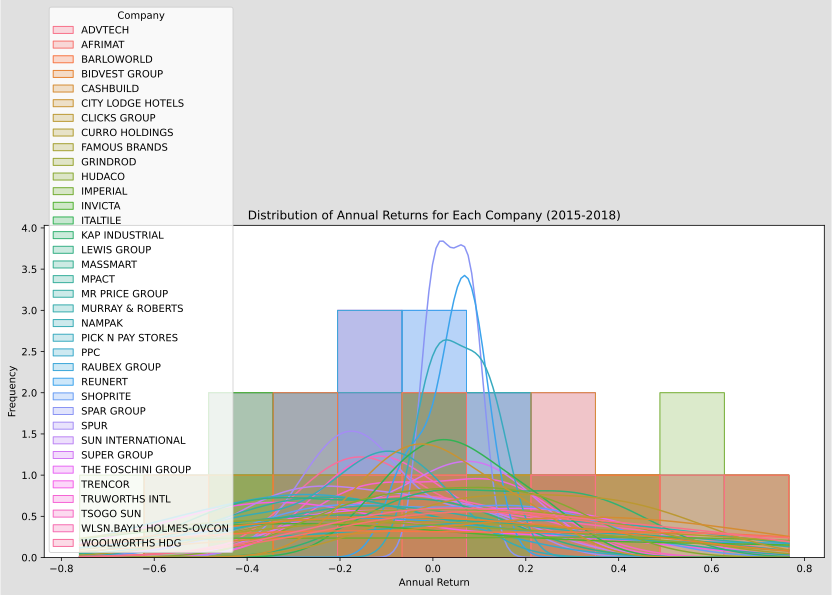

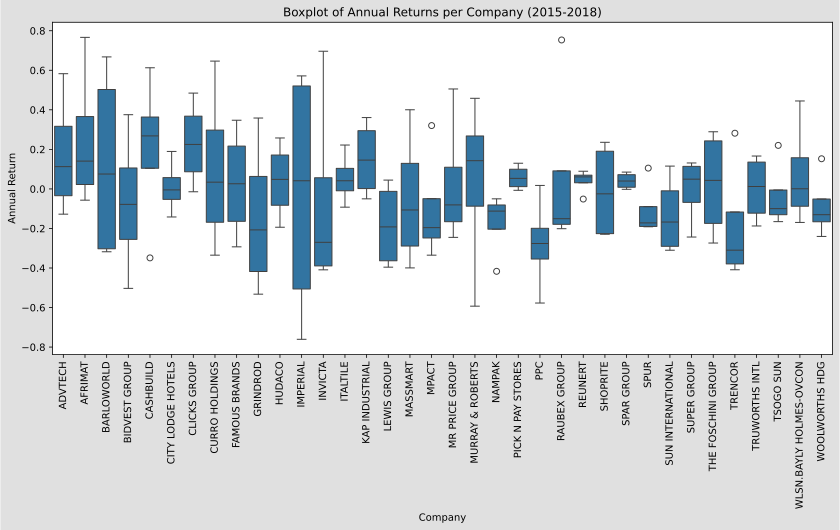

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the annual return for each share in the simulation results
simulation_df["Year"] = simulation_df["Date"].dt.year
annual_returns = []

# Calculate annual return for each company grouped by year
for company, group in simulation_df.groupby(["Company", "Year"]):
    group = group.sort_values("Date")  # Ensure the group is sorted by Date
    # Calculate annual return (Price at end of year / Price at start of year) - 1
    initial_price = group.iloc[0]["Price"]
    ending_price = group.iloc[-1]["Price"]
    annual_return = (ending_price / initial_price) - 1
    annual_returns.append({"Company": company[0], "Year": company[1], "Annual Return": annual_return})

# Convert to DataFrame for analysis
annual_returns_df = pd.DataFrame(annual_returns)

# Plotting the distribution of Annual Returns
plt.figure(figsize=(14, 6))
sns.histplot(data=annual_returns_df, x="Annual Return", hue="Company", kde=True, element="step")
plt.title("Distribution of Annual Returns for Each Company (2015-2018)")
plt.xlabel("Annual Return")
plt.ylabel("Frequency")
plt.show()

# Boxplot to show the spread of Annual Returns for each company
plt.figure(figsize=(14, 6))
sns.boxplot(data=annual_returns_df, x="Company", y="Annual Return")
plt.title("Boxplot of Annual Returns per Company (2015-2018)")
plt.xticks(rotation=90)
plt.show()


We will now proceed to calculate key investment metrics, such as:

Cumulative Return (CR).
Average Annual Return (AAR).
Total Return (TR).
Sharpe Ratio (SR).

Share-Level Analysis of Contributions to AAR
Here we analyze each share's contribution to the Average Annual Return (AAR) for the overall portfolio. This will help us understand which shares positively or negatively influenced the portfolio's performance

Calculate Each Share’s Contribution to AAR
We'll calculate the contribution of each share to the overall Average Annual Return (AAR) for the portfolio by:
1- Weighting each share’s return based on its proportion in the portfolio (assuming equal weighting initially).
2- Summing the weighted returns to get the total AAR contribution for each share.

In [ ]:
from my_module import train_cpt_using_mle, train_cpt_using_bayesian, train_cpt_using_gradient_descent


In [49]:
# Step 1: Define sector portfolios
general_industrials_companies = [
    "SUPER GROUP", "PPC", "NAMPAK", "MURRAY & ROBERTS", "KAP INDUSTRIAL",
    "INVICTA", "IMPERIAL", "BIDVEST GROUP", "BARLOWORLD", "AFRIMAT"
]

consumer_services_companies = [
    "WOOLWORTHS HDG", "TSOGO SUN", "TRUWORTHS INTL"
]

# Step 2: Filter data for each sector
general_industrials_df = simulation_df[simulation_df["Company"].isin(general_industrials_companies)]
consumer_services_df = simulation_df[simulation_df["Company"].isin(consumer_services_companies)]

# Step 3: Calculate sector-specific performance metrics
def calculate_sector_metrics(sector_df, sector_name):
    metrics = []
    for company, group in sector_df.groupby("Company"):
        group = group.sort_values("Date")  # Ensure data is sorted by date for time-series analysis

        # Calculate Cumulative Return (CR)
        initial_price = group.iloc[0]["Price"]
        ending_price = group.iloc[-1]["Price"]
        cumulative_return = (ending_price / initial_price) - 1

        # Calculate Average Annual Return (AAR)
        annual_returns = (group["Price"].pct_change() + 1).dropna()
        average_annual_return = annual_returns.mean()

        # Calculate Total Return (TR)
        total_return = (ending_price - initial_price) / initial_price

        # Calculate Sharpe Ratio (SR)
        risk_free_rate = 0.02  # 2% risk-free rate assumption
        sharpe_ratio = (average_annual_return - risk_free_rate) / annual_returns.std()

        # Append to the metrics list
        metrics.append({
            "Company": company,
            "Cumulative Return (CR)": cumulative_return,
            "Average Annual Return (AAR)": average_annual_return,
            "Total Return (TR)": total_return,
            "Sharpe Ratio (SR)": sharpe_ratio
        })

    # Convert to DataFrame for viewing
    sector_metrics_df = pd.DataFrame(metrics)
    print(f"Performance Metrics for {sector_name} (2015-2018 Period):")
    print(sector_metrics_df)

# Step 4: Calculate and display metrics for General Industrials and Consumer Services
calculate_sector_metrics(general_industrials_df, "General Industrials")
calculate_sector_metrics(consumer_services_df, "Consumer Services")


Performance Metrics for General Industrials (2015-2018 Period):
            Company  Cumulative Return (CR)  Average Annual Return (AAR)  \
0           AFRIMAT                0.676647                     1.014218   
1        BARLOWORLD                0.304850                     1.009258   
2     BIDVEST GROUP               -0.359736                     1.002142   
3          IMPERIAL               -0.670191                     0.987709   
4           INVICTA               -0.542346                     0.988112   
5    KAP INDUSTRIAL                0.599606                     1.011935   
6  MURRAY & ROBERTS               -0.265379                     1.001499   
7            NAMPAK               -0.674959                     0.980666   
8               PPC               -0.724299                     0.981587   
9       SUPER GROUP               -0.008762                     1.001959   

   Total Return (TR)  Sharpe Ratio (SR)  
0           0.676647          12.333178  
1           0.3